<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Project 3: Web APIs & NLP**

### **Part 3: Data Preprocessing and EDA**

---

Import Libraries Here 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import seaborn as sns
from itertools import chain
from wordcloud import WordCloud

import nltk

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

Import Datasets Here 

In [2]:
df = pd.read_csv('../output/depression_happy_cleaned.csv')

In [3]:
df.head()

,id,author,score,total comment,created_utc,subreddit,title_and_body
0,doqwow,SQLwitch,2364,177.0,1572360722,depression,Our most-broken and least-understood rules is ...
1,16kqyd7,SQLwitch,66,395.0,1694923331,depression,"Regular check-in post, with information about ..."
2,1bk9m1a,pan-playdate,176,355.0,1711035875,depression,What's yalls depression food Mine is either Ma...
3,1bkonr0,TheChubbyPlant,21,5.0,1711074477,depression,"Suicides in the US reached over 50k in 2023, t..."
4,1bkkksj,Beneficial-Tax-9093,23,29.0,1711062851,depression,Antidepressants will make sex impossible I've ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13809 entries, 0 to 13808
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              13809 non-null  object 
 1   author          13401 non-null  object 
 2   score           13809 non-null  int64  
 3   total comment   2247 non-null   float64
 4   created_utc     13809 non-null  int64  
 5   subreddit       13809 non-null  object 
 6   title_and_body  13809 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 755.3+ KB


### **Data Dictionary**

|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|*str*|depression_happy_cleaned|Unique ID for each post|
|author|*str*|depression_happy_cleaned|Represents the username of the post owner|
|score|*integer*|depression_happy_cleaned|The post number of posts upvotes minus downvotes|
|total comment|*float*|depression_happy_cleaned|Total number of comments on the reddit post |
|created_utc|*integer*|depression_happy_cleaned|The time stamp when the post is created in UNIX time form|
|subteddit|*str*|depression_happy_cleaned|Name of the subreddit where the post is extracted|
|title_and_body|*str*|depression_happy_cleaned|Content of the post|


### **Data Preprocessing**

---

### **Round 1**

As we are interested in analyzing the text data, we will conduct the following steps to remove unnecessary text inside our data: 
- standardize all words to lowercase 
- Remove special characters
- Stop word removal (with `english` in stopwords)
- Lemmatizing and stemming 

The purpose of this process is to remove special characters words that have no values to our predicition (for example pronouns, symbols), normalize the different forms of words for grammatical purpose into one base form. 

As we have combined the title and body as a column, we will focus on doing preprocessing on this column

#### 1. Standarize All Words to Characters 

In [5]:
df['title_and_body'] = df['title_and_body'].apply(str.lower)

#### 2. Remove Special Characters 

In [6]:
#instantiate Tokenizer
tokenizer = RegexpTokenizer(r'[a-z]\w+') #regex to filter words only 

In [7]:
#create new column for tokenized 
df['tokenize'] = df['title_and_body'].apply(lambda x : tokenizer.tokenize(x))

#### 3. Stops word removal

The purpose of this step is to remove words that have very little significance or meaning to our prediction. They are the common words that are for grammatical structure purposes

In [8]:
#list of no value added english word in the library
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
#create function for stopwords removal
def stop_word_filter(data, stopword = 'english'):
    for i in range(len(data)):
        data[i] = [token for token in data[i] if token not in stopwords.words(stopword)]

    return

In [10]:
#filter with stopwords
stop_word_filter(df['tokenize'])

#### 4. Lemmatization and Stemming 

The purpose of this part code is to normalize the words into their basic forms. We will do lemmatizing and stemming, separate them to 2 new columns for further comparison in the model 

In [11]:
#instantiate lemmatizer 
lemmatizer = WordNetLemmatizer()
#instantiate PorterStemmer
p_stemmer = PorterStemmer()

In [12]:
#create function for lemmatizing and stemming 
def lemma(data, column_name):
    lemma_token = []
    for row in range(len(data[column_name])):
        lemma_token.append([lemmatizer.lemmatize(i, pos = 'v') for i in data[column_name][row]])
    data['lemmatized'] = lemma_token

def stem(data, column_name):
    stem_token = []
    for row in range(len(data[column_name])):
        stem_token.append([p_stemmer.stem(i) for i in data[column_name][row]])
    
    data['stemmed'] = stem_token

In [13]:
#create lemmatized column
lemma(df, column_name='tokenize')

In [14]:
#create stemmed column
stem(df, column_name = 'tokenize')

### **Exploratory Data Analysis (EDA)**

---

#### Plot number of post from each subreddit

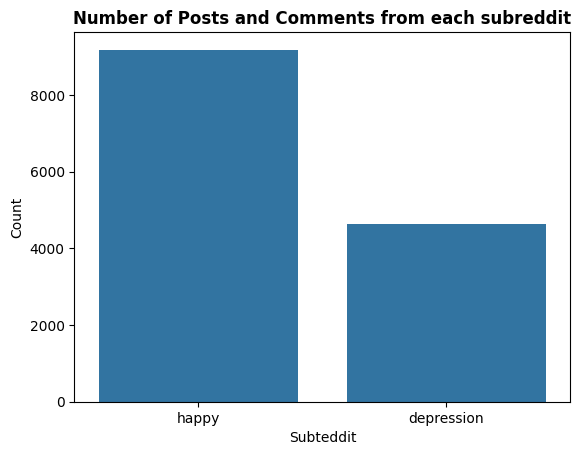

In [15]:
sns.barplot(df['subreddit'].value_counts())
plt.xlabel('Subteddit')
plt.ylabel('Count');
plt.title("Number of Posts and Comments from each subreddit", weight = 'bold');

*Interpretation: The graph above shows the distribution of the number of posts downloaded from each respective subreddits. There are imbalanced class between happy and depression. This part will be further evaluated in modelling part of the notebook*

#### Evaluate the post length from each subreddit
---

In [16]:
#count number of words on each rows 
depression_word_count = df.loc[df['subreddit'] == 'depression']['tokenize'].str.len()
happy_word_count = df.loc[df['subreddit'] == 'happy']['tokenize'].str.len()

In [17]:
depression_word_count.describe()

count    4633.000000
mean       42.222102
std        63.187867
min         0.000000
25%         8.000000
50%        22.000000
75%        53.000000
max      1685.000000
Name: tokenize, dtype: float64

In [18]:
happy_word_count.describe()

count    9176.000000
mean       15.453030
std        28.180036
min         0.000000
25%         2.000000
50%         6.000000
75%        15.000000
max       631.000000
Name: tokenize, dtype: float64

Looking at mean, the average number of words from `r/depression` are 42 and the average number of words from `r/happy` are 16. This shows that post in `r/depression` tends to be longer than `r/happy`

#### Plot histogram for number of words per post 
---

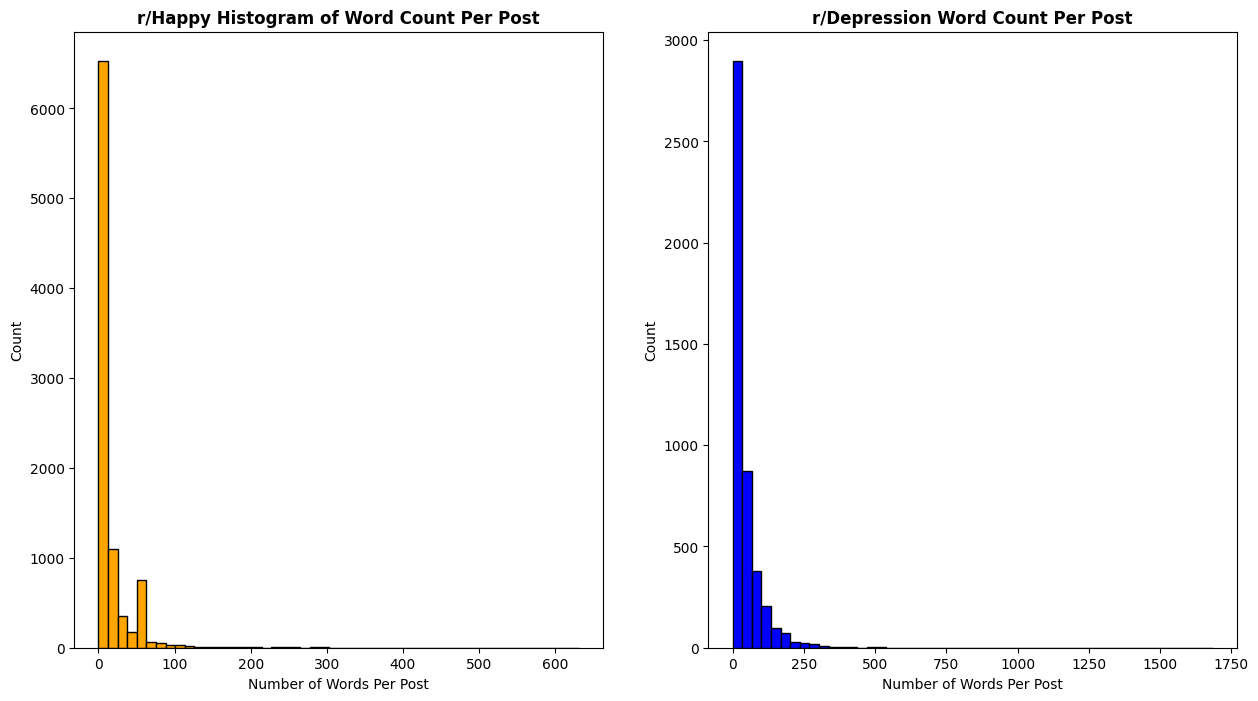

In [19]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

ax[0].hist(happy_word_count, bins = 50, edgecolor = 'black', color = 'orange');
ax[0].set_title("r/Happy Histogram of Word Count Per Post", weight = 'bold');
ax[0].set_xlabel("Number of Words Per Post");
ax[0].set_ylabel("Count");

ax[1].hist(depression_word_count, bins = 50, edgecolor = 'black', color = 'blue');
ax[1].set_title("r/Depression Word Count Per Post", weight = 'bold');
ax[1].set_xlabel("Number of Words Per Post");
ax[1].set_ylabel("Count");

*Intepretation: The graph above shows the distribution of number of words per post for each subreddit. Majority of the post contains around 0-30 words for both subreddit*

#### Plot boxplot to evaluate outliers
---

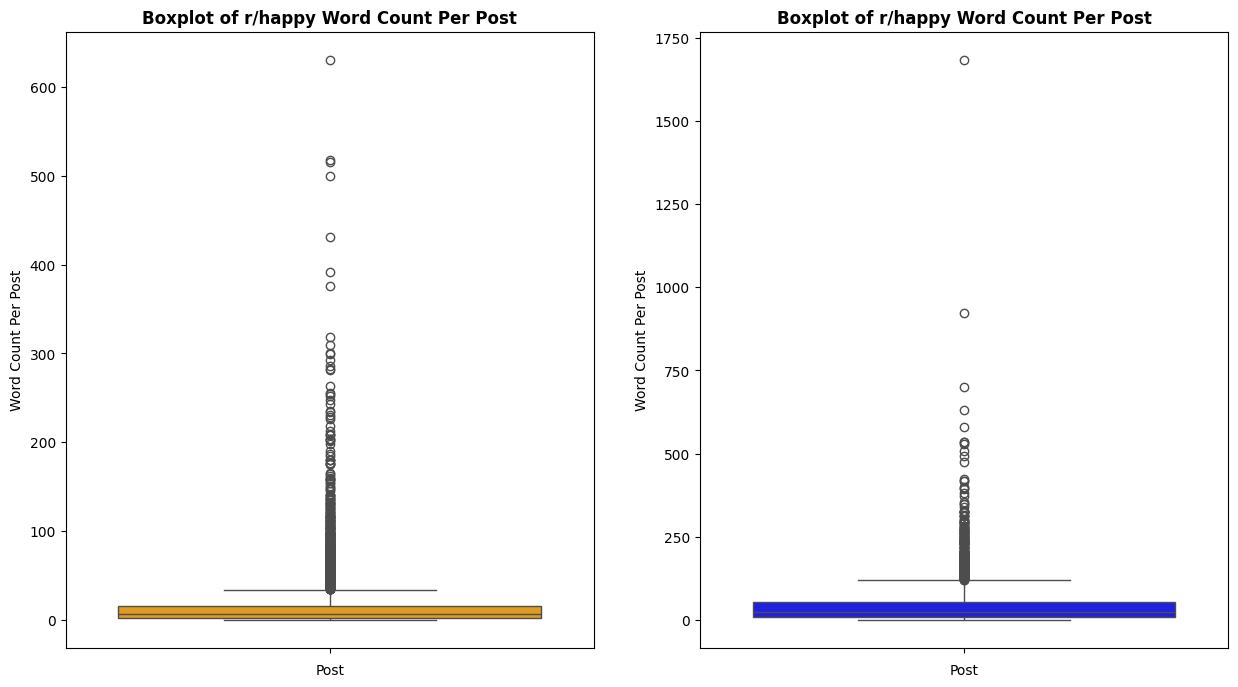

In [20]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

sns.boxplot(data =happy_word_count, ax = ax[0], color = 'orange')
ax[0].set_title("Boxplot of r/happy Word Count Per Post", weight = 'bold')
ax[0].set_xlabel("Post")
ax[0].set_ylabel("Word Count Per Post");

sns.boxplot(data =depression_word_count, ax = ax[1], color = 'blue')
ax[1].set_title("Boxplot of r/happy Word Count Per Post", weight = 'bold')
ax[1].set_xlabel("Post")
ax[1].set_ylabel("Word Count Per Post");

*Interpretation: Based on the boxplot on each subreddit, there are a lot of outliers on each respective subreddit in terms on number of words per post. However, for our NLP model, we breakdown these posts into individual words. The number of posts outliers do not have impact to our model*

### Word Cloud for each Subreddit
---

In [21]:
#create variable to filter lemmatized word with respect to subreddit
happy_lemma = df.loc[df['subreddit'] == 'happy']['lemmatized']
depression_lemma = df.loc[df['subreddit'] == 'depression']['lemmatized']

#create variable to filter stemmed word with respect to subreddit
happy_stem = df.loc[df['subreddit'] == 'happy']['stemmed']
depression_stem = df.loc[df['subreddit'] == 'depression']['stemmed']


In [22]:
depression_lemma_list = list(chain.from_iterable(depression_lemma))
happy_lemma_list = list(chain.from_iterable(happy_lemma))
depression_stem_list = list(chain.from_iterable(depression_stem))
happy_stem_list = list(chain.from_iterable(happy_stem))

In [23]:
#create function to plot wordcloud 
def wordcloud(happy_data, depression_data):
    fig, ax = plt.subplots(1,2, figsize=(20,10));


    wordcloud_happy = WordCloud(max_font_size=50,
                                max_words=50,
                                background_color='white', 
                                stopwords=None,
                                collocations = False,
                                colormap='flag').generate(' '.join(happy_data)) #worcloud reads string input 

    wordcloud_depression = WordCloud(max_font_size=50,
                                max_words=50,
                                background_color='white', 
                                collocations = False,
                                stopwords=None,
                                colormap='flag').generate(' '.join(depression_data))

    ax[0].imshow(wordcloud_happy , interpolation='bilinear');
    ax[0].set_title("r/Happy", weight = 'bold');
    ax[0].axis('off');


    ax[1].imshow(wordcloud_depression , interpolation='bilinear');
    ax[1].set_title("Depression", weight = 'bold');
    ax[1].axis('off');

    plt.show();

    happy_word_frequencies = wordcloud_happy.words_
    depression_word_frequencies = wordcloud_depression.words_
    print(happy_word_frequencies)
    print(depression_word_frequencies)

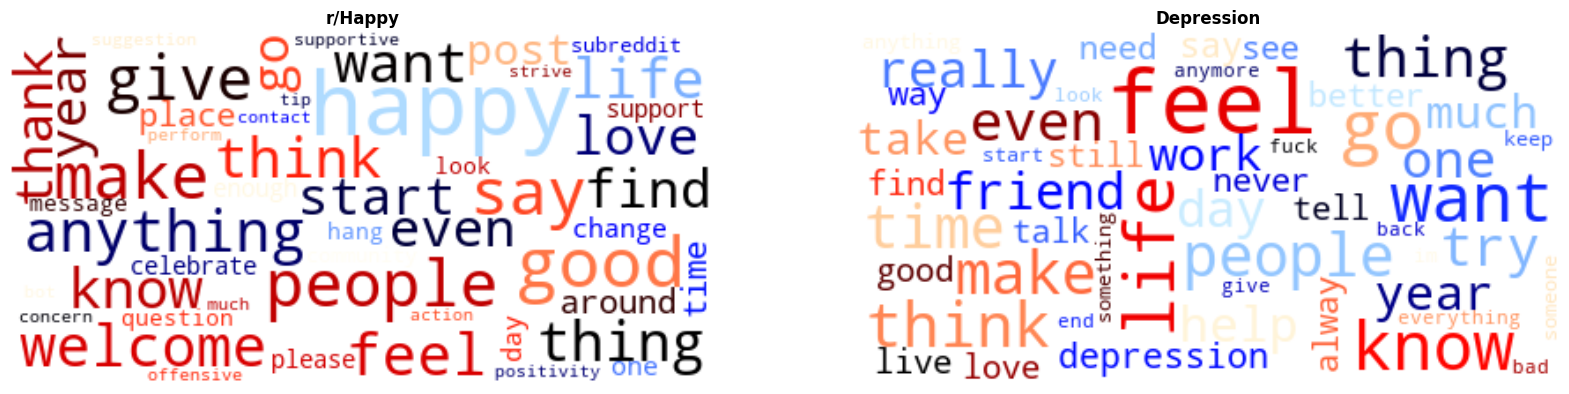

{'happy': 1.0, 'good': 0.61648223645894, 'say': 0.5186371578334305, 'make': 0.5142690739662201, 'people': 0.5133954571927781, 'give': 0.46476412347117063, 'feel': 0.40594059405940597, 'anything': 0.3995340710541642, 'welcome': 0.39487478159580663, 'know': 0.37623762376237624, 'thing': 0.36779266161910307, 'life': 0.36109493302271406, 'think': 0.3538147932440303, 'want': 0.3444962143273151, 'love': 0.30605707629586487, 'thank': 0.30605707629586487, 'even': 0.29819452533488644, 'find': 0.29440885264997085, 'start': 0.29382644146767617, 'year': 0.28829353523587653, 'go': 0.2769365171811299, 'post': 0.24694234129295284, 'place': 0.23733255678509027, 'time': 0.23587652882935353, 'around': 0.23092603377984858, 'change': 0.22830518345952241, 'day': 0.22393709959231217, 'one': 0.22364589400116483, 'please': 0.21694816540477577, 'enough': 0.20762958648806057, 'support': 0.2050087361677344, 'celebrate': 0.2050087361677344, 'question': 0.20297029702970298, 'hang': 0.19918462434478743, 'look': 0.1

In [24]:
wordcloud(happy_lemma_list,depression_lemma_list)

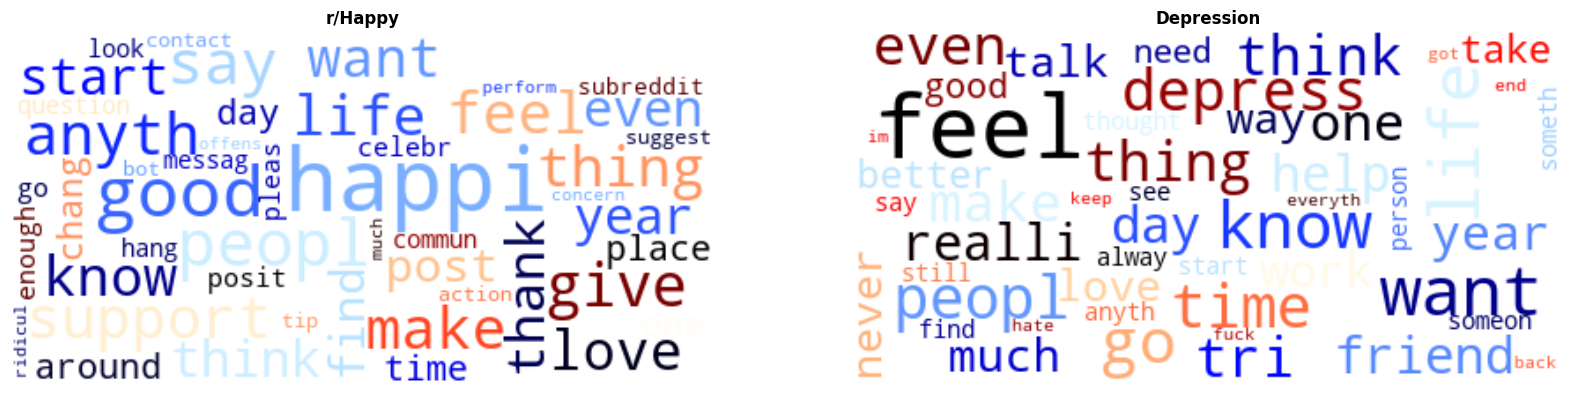

{'happi': 1.0, 'good': 0.5899500277623543, 'peopl': 0.48945030538589673, 'say': 0.43614658523042754, 'give': 0.40893947806774017, 'feel': 0.3870072182121044, 'anyth': 0.38089950027762354, 'support': 0.3775680177679067, 'make': 0.3767351471404775, 'welcom': 0.3764575235980011, 'thing': 0.35063853414769575, 'life': 0.3442531926707385, 'know': 0.32926152137701276, 'want': 0.32842865074958355, 'love': 0.3181565796779567, 'thank': 0.3009439200444198, 'think': 0.2848417545807885, 'even': 0.28428650749583567, 'start': 0.2801221543586896, 'year': 0.27484730705163796, 'post': 0.2354247640199889, 'find': 0.23209328151027206, 'place': 0.22626318711826762, 'time': 0.2248750694058856, 'around': 0.22015546918378678, 'chang': 0.21765685730149917, 'day': 0.21349250416435314, 'one': 0.21321488062187674, 'posit': 0.2090505274847307, 'pleas': 0.2068295391449195, 'go': 0.20183231538034424, 'enough': 0.19794558578567462, 'celebr': 0.19766796224319821, 'question': 0.1935036091060522, 'commun': 0.18989450305

In [25]:
wordcloud(happy_stem_list,depression_stem_list)

### Plot Single Word Frequncies
---

In [26]:
#create function to plot words frequencies

def plot_word(happy_data, depression_data):
    happy_word_count = nltk.FreqDist(chain.from_iterable(happy_data)) #combine lists of list into 1 list for happy

    df_happycount = pd.DataFrame(happy_word_count.most_common(30), columns = ['word', 'count'])#create a dataframe 

    depression_word_count = nltk.FreqDist(chain.from_iterable(depression_data)) #combine lists of list into 1 list for depression

    df_depressioncount = pd.DataFrame(depression_word_count.most_common(30), columns = ['word', 'count'])

    fig, ax = plt.subplots(1,2, figsize=(20,10))
    #plot graph for number of words 
    sns.barplot(x ='count', y='word', data=df_happycount, ax= ax[0], color='orange')
    sns.barplot(x ='count', y='word', data=df_depressioncount, ax= ax[1], color='blue')

    #label graph for r/happy
    ax[0].set_title("r/happy Top Word Frequncies", weight = 'bold');
    ax[0].set_xlabel("Count");
    ax[0].set_ylabel('Word');

    #show numbers on the graph
    for index, value in enumerate(df_happycount['count']):
        ax[0].text(value/2, index, str(value), color='white', ha='left', va = 'center');

    #label graph for r/depression
    ax[1].set_title("r/depression Top Word Frequncies", weight = 'bold');
    ax[1].set_xlabel("Count");
    ax[1].set_ylabel('Word');

    #show numbers on the graph
    for index,value in enumerate(df_depressioncount['count']):
        ax[1].text(value/2, index, str(value), color = 'white', va= 'center')

1. Lemmatized words 

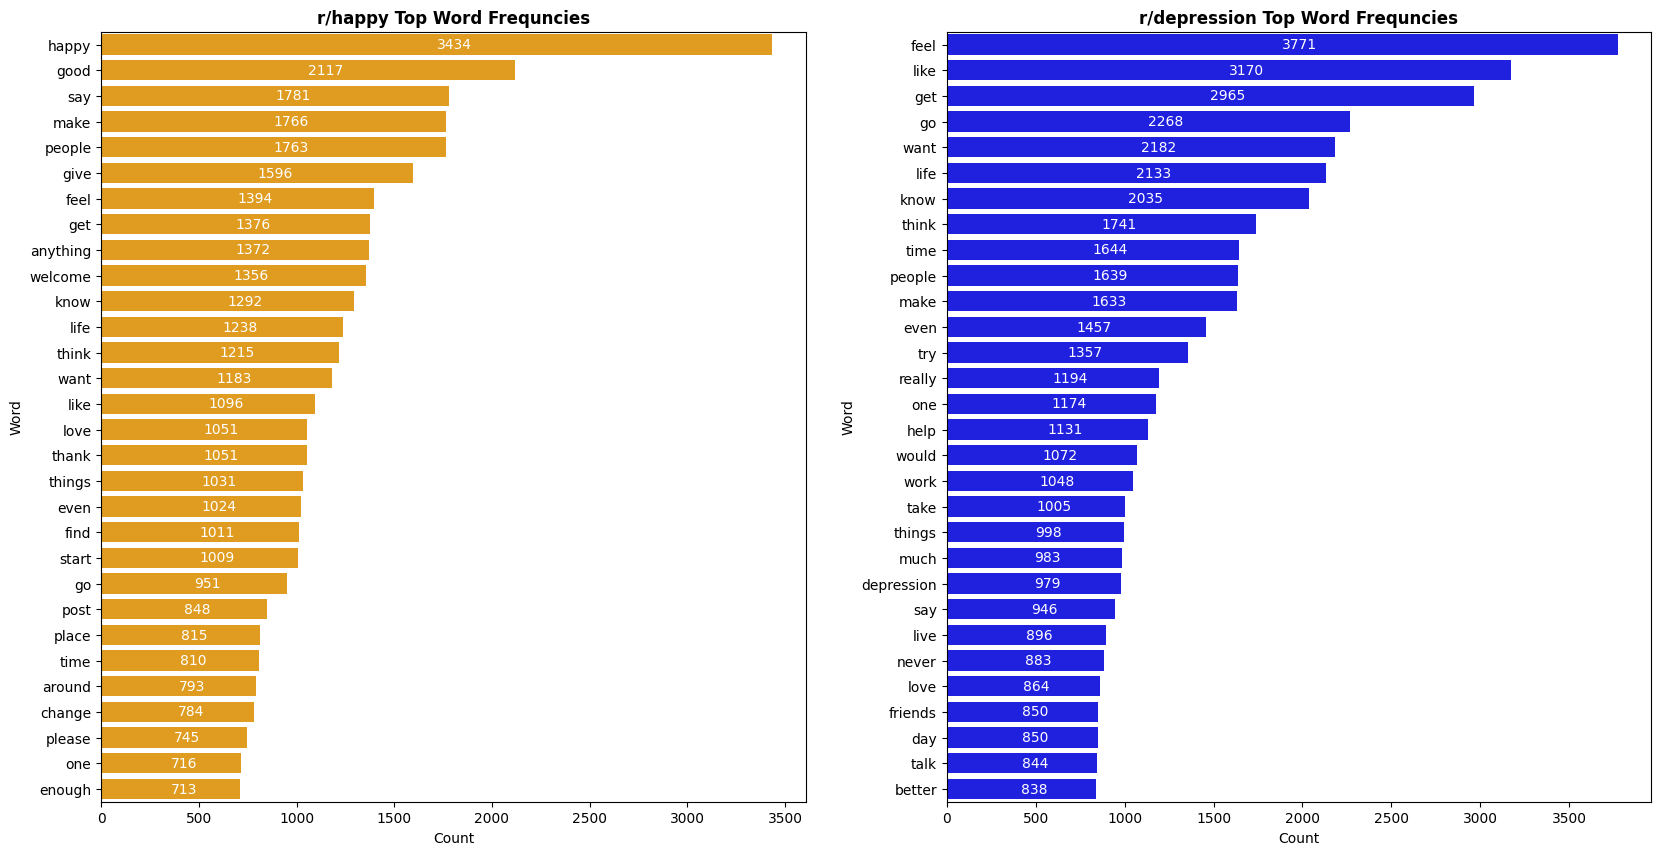

In [27]:
plot_word(happy_lemma,depression_lemma)

2. Stemmed Words

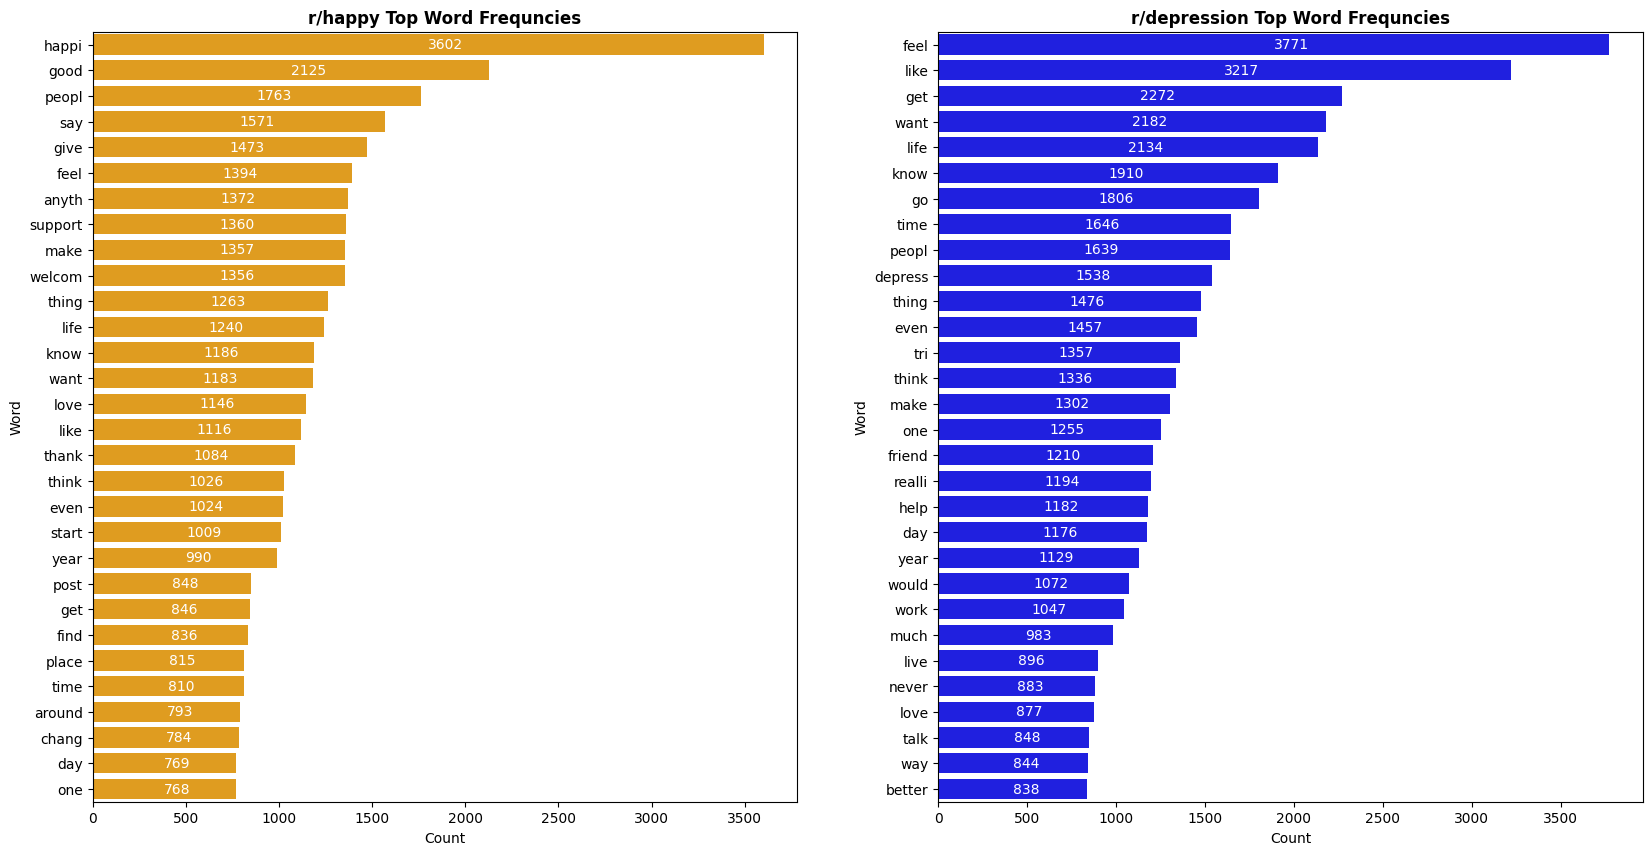

In [28]:
plot_word(happy_stem,depression_stem)

#### Plot for 2 Grams Words
---

1. Lemmatized words

In [29]:
df_happy = df[df['subreddit'] == 'happy'].reset_index(drop = True)
df_depression = df[df['subreddit'] == 'depression'].reset_index(drop = True)

#create variable to filter lemmatized word with respect to subreddit
happy_lemma = df.loc[df['subreddit'] == 'happy']['lemmatized']
depression_lemma = df.loc[df['subreddit'] == 'depression']['lemmatized']

In [30]:
#create function to get top 20 most used words
def twograms(data,title):
    #Instantiate model
    cvec = CountVectorizer(ngram_range = (2,2))
    #fit and transform model
    two_gram = cvec.fit_transform([' '.join(word) for word in data[title]])
    #convert to dataframe
    df_two_gram = pd.DataFrame(two_gram.toarray(),columns = cvec.get_feature_names_out())
    #get top 20 highest count for two words
    top30 = pd.DataFrame(df_two_gram.sum(axis=0).sort_values(ascending=False)[0:30], columns=['count'])
    #add words columns to dataframe 
    top30['words'] = top30.index
    #convert index to numeric
    top30.index = range(len(top30))

    return top30


In [31]:
#call function to get top30 2 grams from both subreddit
twograms_depression = twograms(df_depression, 'lemmatized')
twograms_happy = twograms(df_happy,'lemmatized')

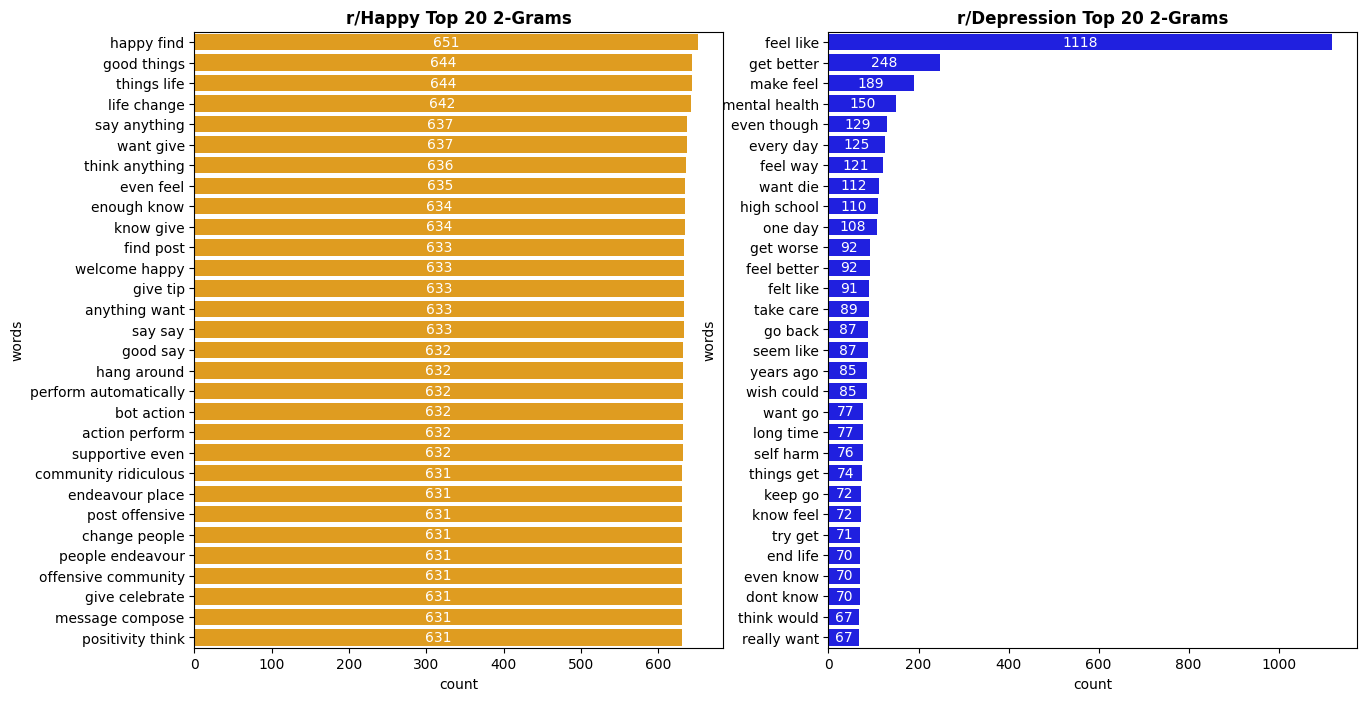

In [32]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

#plot graph for r/happy
sns.barplot(x = 'count', y= 'words', data = twograms_happy, ax = ax[0], color = 'orange');
ax[0].set_title('r/Happy Top 20 2-Grams', weight = 'bold')

#show numbers on graph 
for index, value in enumerate(twograms_happy['count']):
    ax[0].text(value/2, index, str(value), color='white', ha='center', va = 'center');


#plot graph for r/depression
sns.barplot(x = 'count', y= 'words', data = twograms_depression, ax = ax[1], color = 'blue');
ax[1].set_title('r/Depression Top 20 2-Grams', weight = 'bold');

for index, value in enumerate(twograms_depression['count']):
    ax[1].text(value/2, index, str(value), color = 'white', ha= 'center', va= 'center')

r/happy is a moderated subreddit, the first comments in every post is by the moderator. That is why there are a lot of uniform words in our graph

2. Stemmed words

In [33]:
#call function to get top20 2 grams from both subreddit
twograms_depression_stem = twograms(df_depression, 'stemmed')
twograms_happy_stem = twograms(df_happy,'stemmed')

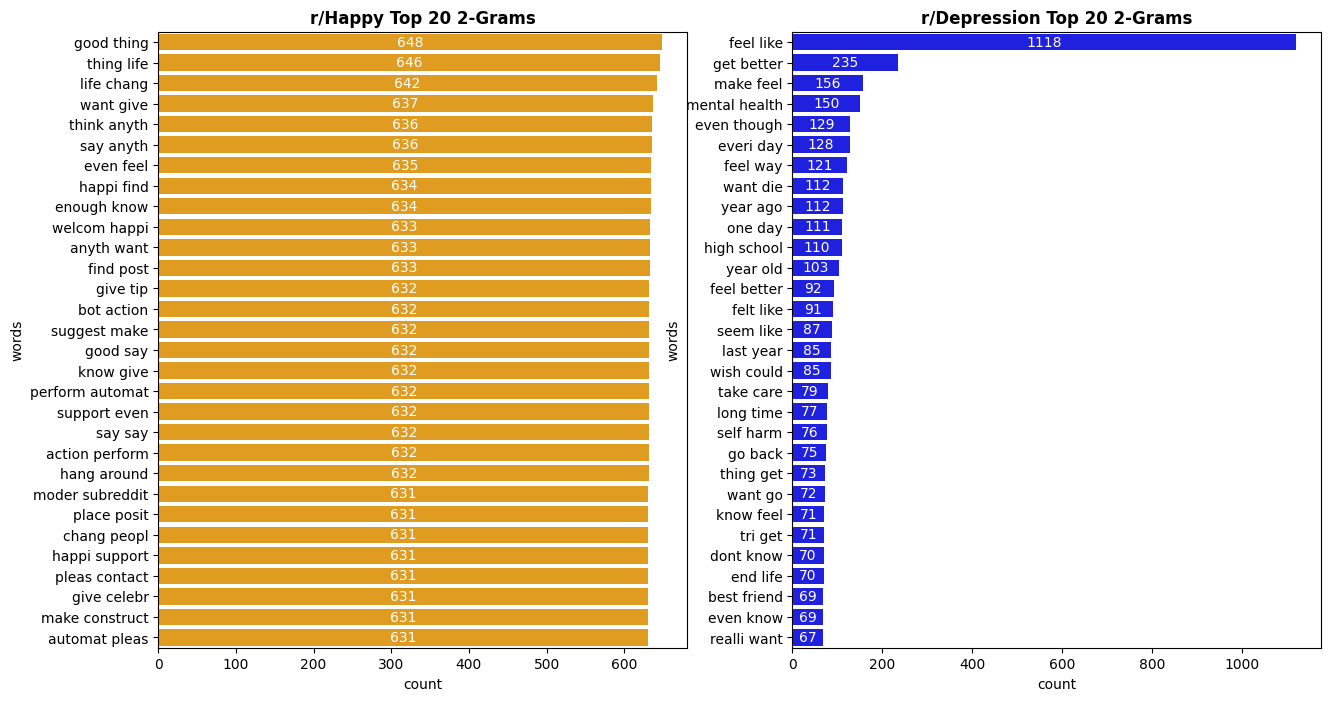

In [34]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

#plot graph for r/happy
sns.barplot(x = 'count', y= 'words', data = twograms_happy_stem, ax = ax[0], color = 'orange');
ax[0].set_title('r/Happy Top 20 2-Grams', weight = 'bold')

#show numbers on graph 
for index, value in enumerate(twograms_happy_stem['count']):
    ax[0].text(value/2, index, str(value), color='white', ha='center', va = 'center');


#plot graph for r/depression
sns.barplot(x = 'count', y= 'words', data = twograms_depression_stem, ax = ax[1], color = 'blue');
ax[1].set_title('r/Depression Top 20 2-Grams', weight = 'bold');

for index, value in enumerate(twograms_depression_stem['count']):
    ax[1].text(value/2, index, str(value), color = 'white', ha= 'center', va= 'center')

r/happy is a moderated subreddit, the first comments in every post is by the moderator. That is why there are a lot of uniform words in our graph

Looking at comparison between `stemmed` and `lemmatized` words, `lemmatized` produce words that are registered in dictionary. We will continue to do further filtering using lemmatized words 

#### Plot Venn Diagram for Top 100 Words between r/depression and r/happy

In [35]:
#create function to get top 100 words
def top100(data,title):
    #Instantiate model
    cvec = CountVectorizer()
    #fit and transform model
    one_gram = cvec.fit_transform([' '.join(word) for word in data[title]])
    #convert to dataframe
    df_one_gram = pd.DataFrame(one_gram.toarray(),columns = cvec.get_feature_names_out())
    #get top 20 highest count for two words
    top100 = pd.DataFrame(df_one_gram.sum(axis=0).sort_values(ascending=False)[0:100], columns=['count'])
    #add words columns to dataframe 
    top100['words'] = top100.index
    #convert index to numeric
    top100.index = range(len(top100))

    return top100


In [36]:
#call function and store to following variables
depression_top_100 = top100(df_depression,'lemmatized')
happy_top_100 = top100(df_happy,'lemmatized')

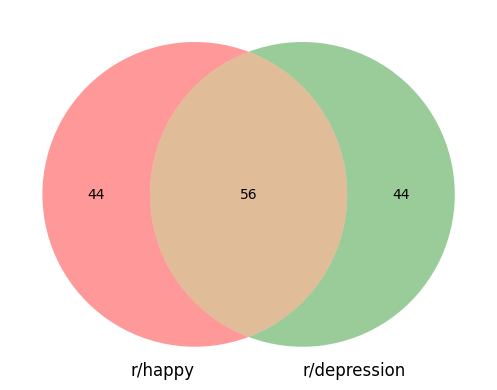

In [37]:
#plot venn diagram 
venn2(subsets=(set(happy_top_100['words']), set(depression_top_100['words'])),
      set_labels=('r/happy', 'r/depression'));

Based on the venn diagram, we found that there are a lot of similar top 100 words between r/happy and r/depression. We will filter these similar words to create clearer classfication between r/depression and r/happy

In [38]:
#identify common words
common_words = set(depression_top_100['words'].tolist()) & set(happy_top_100['words'].tolist())

### **Round 2: Filtering with Custom Stopwords and Common Words**

---

As using stopwords 'english' only is not enough to filter out unwanted words, we will create a new list of custom words to filter out words that do not have values.

In [39]:
custom_stopwords = ['ur','us','may','many', 'nd', 'either', 'might', 'unless',
                    'even', 'https', 'en', 'org', 'name', 'two' , 'im', 'ive',
                    'yet', 'two', 'op', 'ops', 'usually', 'pm', 'pms', 'else',
                    'often', 'ones', 'would', 'alt', 'others', 'except', 'many',
                    'much','also', 'always', 'www', 'com', 'since', 'everyone',
                    'ysk', 'yalls', 'cuz','coulda', 'really', 'day', 'ei',
                    'ol', 'nada', 'year','years', 'oc', 'month', 'hours','week',
                    'day', 'awwww', 'btw'
                    ]

We will also apply stopwords to remove common words between both subreddit

In [40]:
#create function for stopwords removal
def custom_stopword_filter(data, stopword):
    for i in range(len(data)):
        data[i] = [word for word in data[i] if word not in stopword]

    return

In [41]:
#filter based on created custom stopwrod 
custom_stopword_filter(df['lemmatized'],stopword=custom_stopwords)

In [42]:
#filter based on common words
custom_stopword_filter(df['lemmatized'], stopword=common_words)

#### Plot Venn Diagram for Top 100 Words between r/depression and r/happy
---

In [43]:
df_happy = df[df['subreddit'] == 'happy'].reset_index(drop = True)
df_depression = df[df['subreddit'] == 'depression'].reset_index(drop = True)

#call function and store to following variables
depression_top_100 = top100(df_depression,'lemmatized')
happy_top_100 = top100(df_happy,'lemmatized')

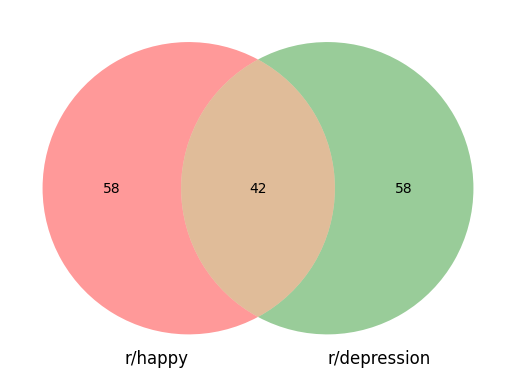

In [44]:
#plot venn diagram 
venn2(subsets=(set(happy_top_100['words']), set(depression_top_100['words'])),
      set_labels=('r/happy', 'r/depression'));

As there are still a lot of common words between r/happy and r/depression, we will conduct another round of common word filter

In [45]:
common_words = set(depression_top_100['words'].tolist()) & set(happy_top_100['words'].tolist())

### **Round 3: Filtering with Common Words**
---

In [46]:
#filter based on common words
custom_stopword_filter(df['lemmatized'], stopword=common_words)

#### Plot Venn Diagram for Top 100 Words between r/depression and r/happy
---

In [47]:
df_happy = df[df['subreddit'] == 'happy'].reset_index(drop = True)
df_depression = df[df['subreddit'] == 'depression'].reset_index(drop = True)

#call function and store to following variables
depression_top_100 = top100(df_depression,'lemmatized')
happy_top_100 = top100(df_happy,'lemmatized')

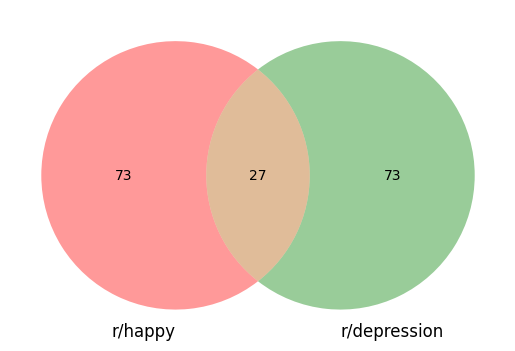

In [48]:
#plot venn diagram 
venn2(subsets=(set(happy_top_100['words']), set(depression_top_100['words'])),
      set_labels=('r/happy', 'r/depression'));

Since there are not significant similar top 100 words, we will use these filtered words for our modelling

#### Plot Single Word Frequncies (After Common Words Filter)
---

In [49]:
df_happy = df[df['subreddit'] == 'happy'].reset_index(drop = True)
df_depression = df[df['subreddit'] == 'depression'].reset_index(drop = True)

#create variable to filter lemmatized word with respect to subreddit
happy_lemma = df.loc[df['subreddit'] == 'happy']['lemmatized']
depression_lemma = df.loc[df['subreddit'] == 'depression']['lemmatized']

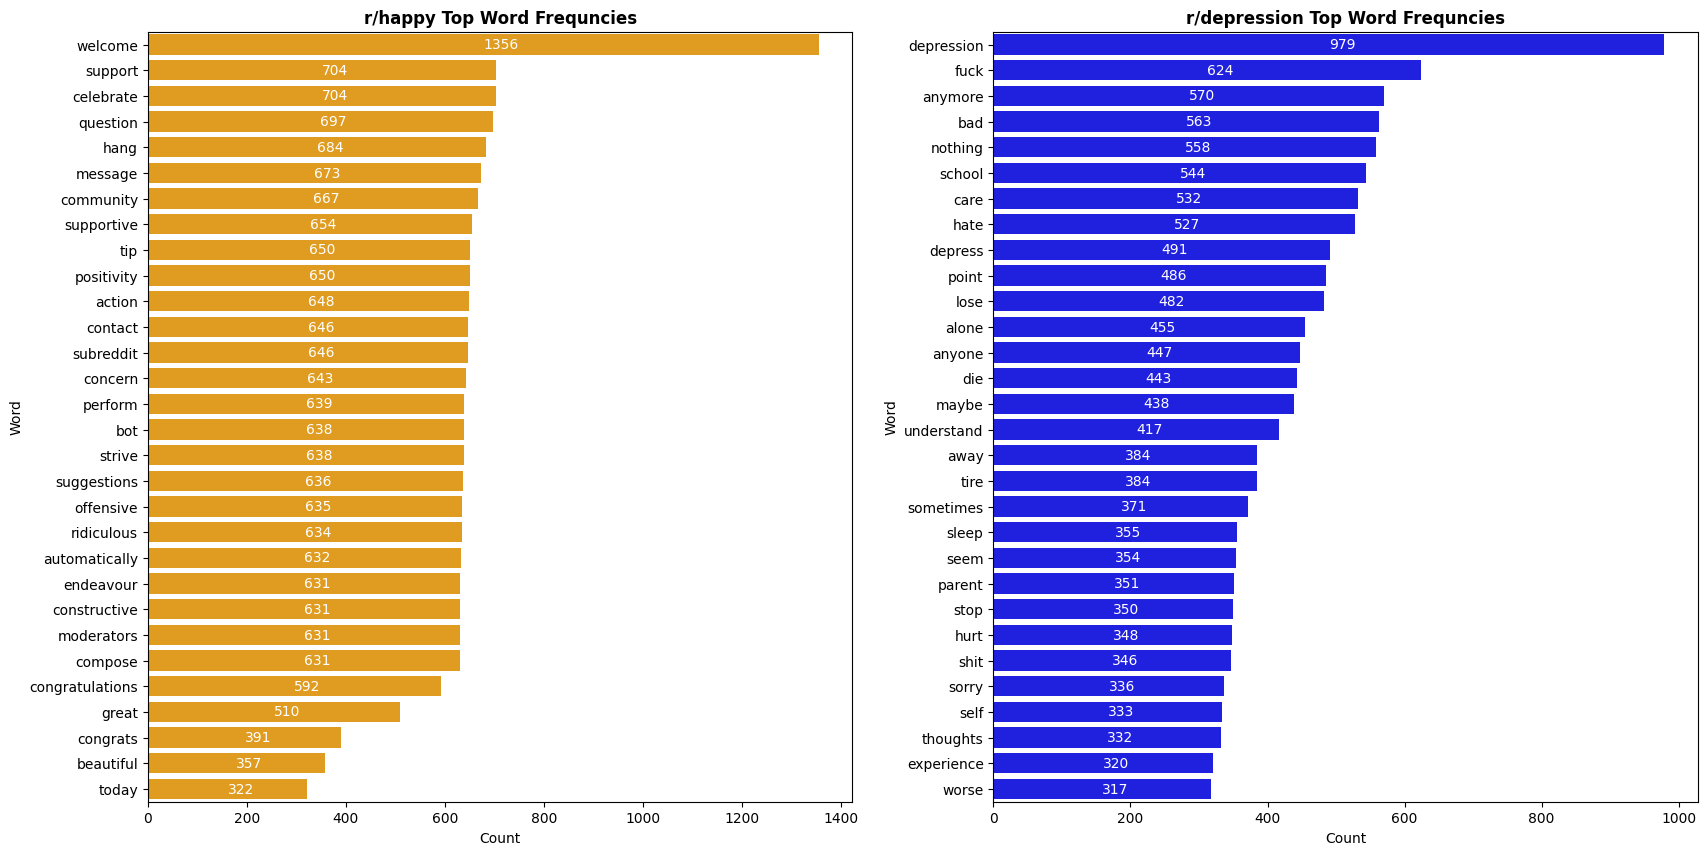

In [50]:
plot_word(happy_lemma,depression_lemma)

#### Plot for 2 Grams Words (After Stop Word Filter)
---

In [51]:
#call function to get top30 2 grams from both subreddit
twograms_depression = twograms(df_depression, 'lemmatized')
twograms_happy = twograms(df_happy,'lemmatized')

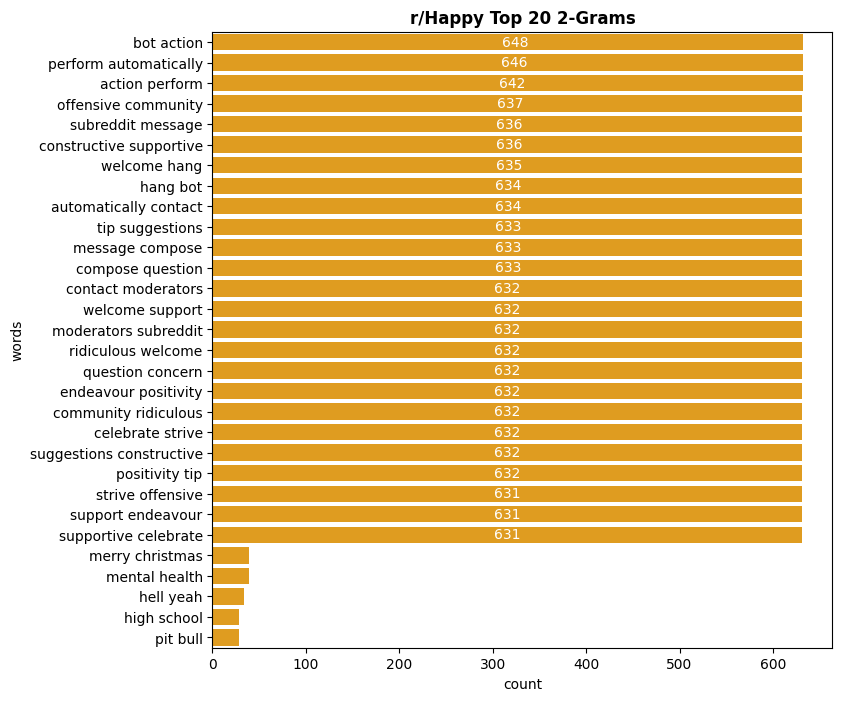

In [52]:
plt.figure(figsize=(8,8))

#plot graph for r/happy
sns.barplot(x = 'count', y= 'words', data = twograms_happy, color = 'orange');
plt.title('r/Happy Top 20 2-Grams', weight = 'bold')

#show numbers on graph 
for index, value in enumerate(twograms_happy_stem['count']):
    plt.text(value/2, index, str(value), color='white', ha='center', va = 'center');




r/happy is a moderated subreddit, the first comments in every post is by the moderator. That is why there are a lot of uniform words in our graph

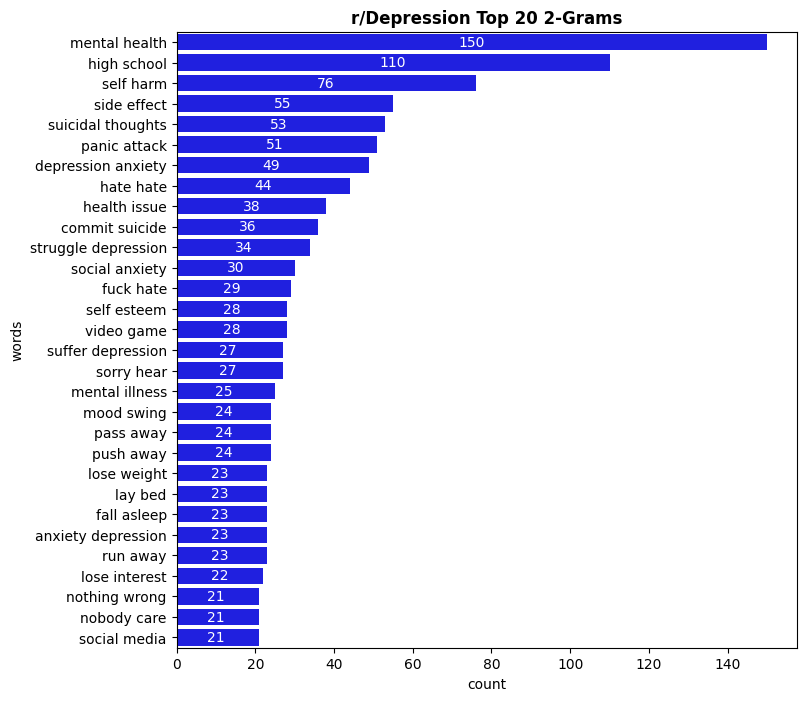

In [53]:
plt.figure(figsize = (8,8))
sns.barplot(x='count', y='words', data=twograms_depression, color='blue')
plt.title('r/Depression Top 20 2-Grams', weight='bold')

# Add annotations
for index, value in enumerate(twograms_depression['count']):
    plt.text(value//2, index, str(value), color='white', ha='center', va='center')

# Show the plot
plt.show()

#### Plot Word Cloud (After Common Word Filter )
---

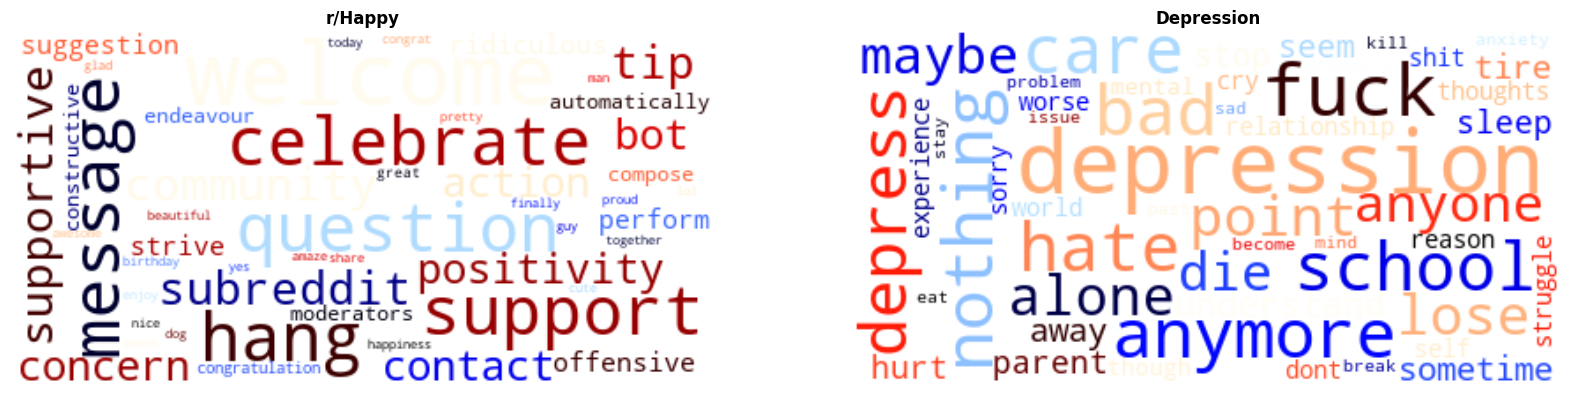

{'welcome': 1.0, 'support': 0.5191740412979351, 'celebrate': 0.5191740412979351, 'question': 0.5140117994100295, 'hang': 0.504424778761062, 'message': 0.4963126843657817, 'community': 0.4918879056047198, 'subreddit': 0.4830383480825959, 'supportive': 0.4823008849557522, 'tip': 0.47935103244837757, 'positivity': 0.47935103244837757, 'action': 0.4778761061946903, 'contact': 0.47640117994100295, 'bot': 0.4756637168141593, 'concern': 0.474188790560472, 'suggestion': 0.47271386430678464, 'perform': 0.47123893805309736, 'strive': 0.47050147492625366, 'offensive': 0.46828908554572274, 'ridiculous': 0.46755162241887904, 'automatically': 0.46607669616519176, 'endeavour': 0.46533923303834807, 'constructive': 0.46533923303834807, 'moderators': 0.46533923303834807, 'compose': 0.46533923303834807, 'congratulation': 0.43805309734513276, 'great': 0.37610619469026546, 'congrat': 0.2890855457227139, 'beautiful': 0.26327433628318586, 'today': 0.23893805309734514, 'amaze': 0.2323008849557522, 'proud': 0.

In [54]:
depression_lemma_list = list(chain.from_iterable(depression_lemma))
happy_lemma_list = list(chain.from_iterable(happy_lemma))
wordcloud(happy_lemma_list,depression_lemma_list)

### Export Pre-Processed Datasets to csv File for Modelling 

In [55]:
# df.to_csv('../output/depression_happy_processed.csv', index=False )

#### Next: [Part 4 Modelling](Part_4_modelling.ipynb)